In [ ]:
# !pip install langchain-openai langchain-community langgraph langchain-tavily

In [ ]:
# langchain
from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langchain_core.tools import tool

# langgraph

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

#utils
from datetime import datetime
from typing import Annotated
from typing_extensions import TypedDict


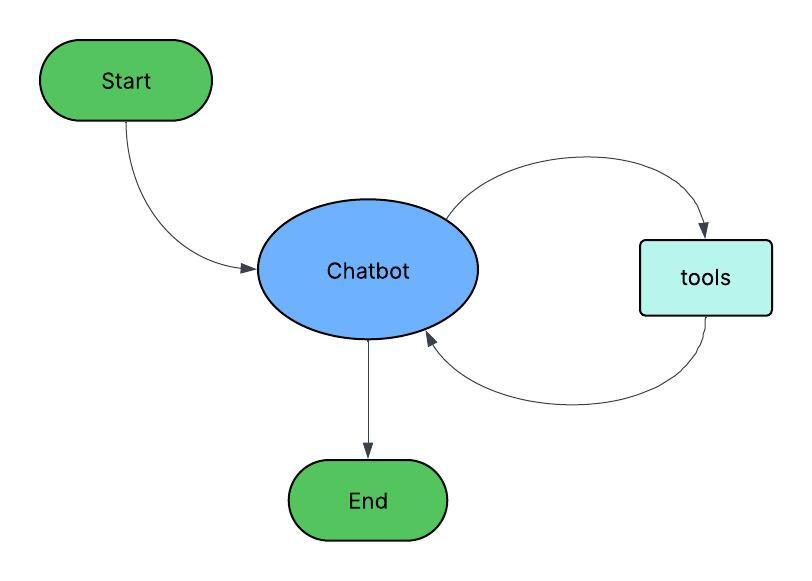

In [ ]:
from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')

tavily_api_key = userdata.get('TAVILY_API_KEY')



In [ ]:
llm= ChatOpenAI(api_key= api_key, model="gpt-4o")

In [ ]:
@tool
def get_current_time():
  """Get the current time before making decision"""
  return datetime.now().strftime("%H:%M:%S")

In [ ]:
# tool 2

tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key, max_results=5)

In [ ]:
tools = [tavily_search, get_current_time]

In [ ]:
llm_with_tools = llm.bind_tools(tools)

In [ ]:
#tools are created and bind to the llm model

In [ ]:
class State(TypedDict):
  messages: Annotated[list, add_messages]

In [ ]:
def chatbot(state:State):
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [ ]:
graph_builder = StateGraph(State)

In [ ]:
graph_builder.add_node("chatbot", chatbot)

In [ ]:
tools_node = ToolNode(tools)

In [ ]:
graph_builder.add_node("tools", tools_node)

In [ ]:
graph_builder.add_conditional_edges("chatbot", tools_condition)

In [ ]:
graph_builder.add_edge("tools", "chatbot")

In [ ]:
graph_builder.set_entry_point("chatbot")

In [ ]:
graph= graph_builder.compile()

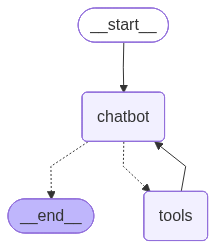

In [ ]:
graph

In [ ]:
# Test Chabot

In [ ]:
from IPython.display import  Markdown
def render_output(string):
  display(Markdown(string))

In [ ]:
def process_stream(stream):
  for s in stream:
    message = s["messages"][-1]
    if isinstance (message, tuple):
      print(message)
    else:
      message.pretty_print()
  return message

In [ ]:
def process_query(query, config=None):
  input  = {"messages": [{"role": "user", "content":query}]}
  message = process_stream(graph.stream(input, config, stream_mode="values"))
  render_output(f"## Answer:\n {message.content}")

In [ ]:
#start testing
process_query("Hello my first mini gpt project")

================================ Human Message =================================

Hello my first mini gpt project
================================== Ai Message ==================================

Hello! That sounds exciting! What is your project about? Are you working on something specific related to GPT technology?


## Answer:
 Hello! That sounds exciting! What is your project about? Are you working on something specific related to GPT technology?

In [ ]:
process_query("who is current prime minister of india")

================================ Human Message =================================

who is current prime minister of india
================================== Ai Message ==================================
Tool Calls:
  get_current_time (call_btZyBwcLG8kVEwifUAYZyelX)
 Call ID: call_btZyBwcLG8kVEwifUAYZyelX
  Args:
================================= Tool Message =================================
Name: get_current_time

02:35:16
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_BBDAY5BpL66ZBRstQe2m6MQ9)
 Call ID: call_BBDAY5BpL66ZBRstQe2m6MQ9
  Args:
    query: current Prime Minister of India
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Prime Minister of India - Wikipedia", "url": "https://en.wikipedia.org/wiki/Prime_Minister_of_India", "content": "Narasimha Rao, Atal Bihari Vajpayee, Manmohan Singh, and Narendra Modi, who is the curr

## Answer:
 The current Prime Minister of India is Narendra Modi. He has been serving since May 26, 2014.

In [ ]:
process_query("what is today's date in india")

================================ Human Message =================================

what is today's date in india
================================== Ai Message ==================================
Tool Calls:
  get_current_time (call_KfHjk9fkwqjUghbLOpcToBmE)
 Call ID: call_KfHjk9fkwqjUghbLOpcToBmE
  Args:
================================= Tool Message =================================
Name: get_current_time

02:36:13
================================== Ai Message ==================================

I'm unable to retrieve the current date, but it's 2:36 AM.


## Answer:
 I'm unable to retrieve the current date, but it's 2:36 AM.

# Memory

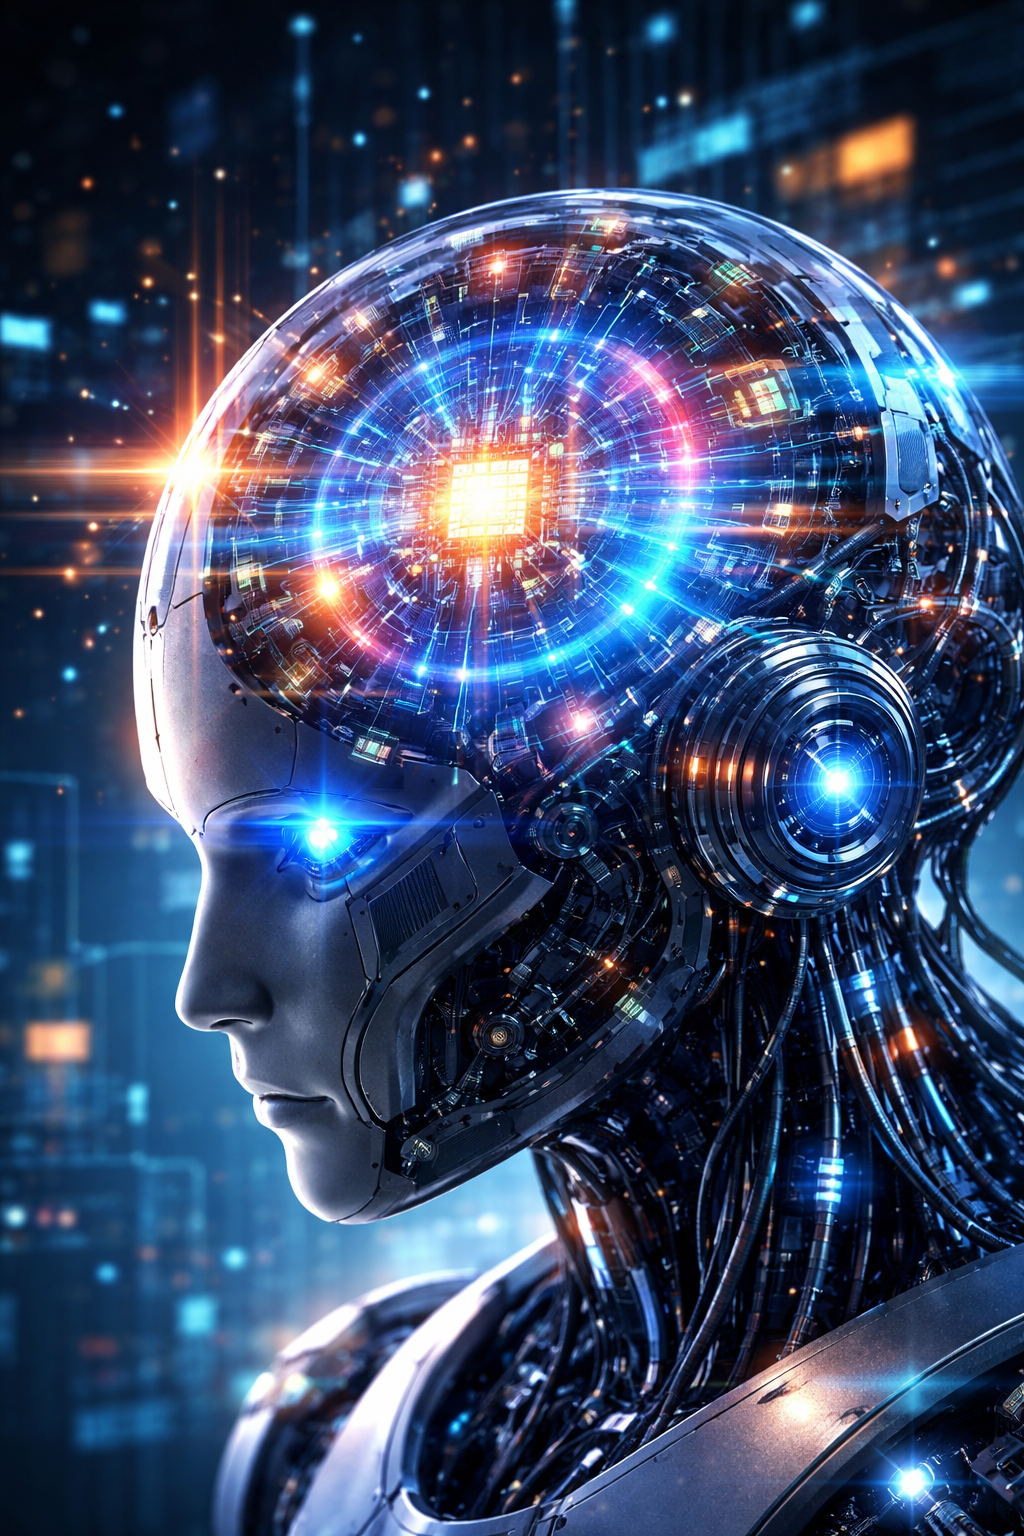

In [ ]:
process_query("My name is kushagra, call me bruce wyne")

================================ Human Message =================================

My name is kushagra, call me bruce wyne
================================== Ai Message ==================================

Alright, Bruce Wyne! How can I assist you today?


## Answer:
 Alright, Bruce Wyne! How can I assist you today?

In [ ]:
process_query("what is my name")

================================ Human Message =================================

what is my name
================================== Ai Message ==================================

I'm sorry, but I can't determine your name. Can I help you with anything else?


## Answer:
 I'm sorry, but I can't determine your name. Can I help you with anything else?

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [ ]:
graph = graph_builder.compile(checkpointer=memory)

In [ ]:
config_user_1 = {"thread_id": "user_1"}

In [ ]:
process_query("My name is kushagra, call me bruce wyne", config=config_user_1)

================================ Human Message =================================

My name is kushagra, call me bruce wyne
================================== Ai Message ==================================

Got it, Bruce Wyne! How can I assist you today?


## Answer:
 Got it, Bruce Wyne! How can I assist you today?

In [ ]:
process_query("what is my name", config=config_user_1)

================================ Human Message =================================

what is my name
================================== Ai Message ==================================

Your name is Bruce Wyne.


## Answer:
 Your name is Bruce Wyne.

In [ ]:
config_user_2 = {"thread_id": "user_2"}

In [ ]:
process_query("what is my name", config=config_user_2)

================================ Human Message =================================

what is my name
================================== Ai Message ==================================

I'm sorry, but I don't have the ability to know your name unless you tell me directly. If you'd like, you can share your name with me!


## Answer:
 I'm sorry, but I don't have the ability to know your name unless you tell me directly. If you'd like, you can share your name with me!

In [ ]:
# End of chapter 1